In [9]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import pickle
from datasets import load_from_disk
from pathlib import Path

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

PROJECT_ROOT = Path("/home/SpeakerRec/BioVoice")

DATASET_PATH = (
    PROJECT_ROOT / "data" / "datasets" / "asv_spoof_2019" / "probe_20spk_50_50"
)
probe_ds = load_from_disk(DATASET_PATH)

print("Probe dataset size:", len(probe_ds))

redim_model = (
    torch.hub.load(
        "IDRnD/ReDimNet",
        "ReDimNet",
        model_name="b5",
        train_type="ptn",
        dataset="vox2",
    )
    .to(DEVICE)
    .eval()
)

Probe dataset size: 2000


Using cache found in /home/SpeakerRec/.cache/torch/hub/IDRnD_ReDimNet_master


In [ ]:
def extract_embeddings(dataset, model):
    X = []
    y = []

    for sample in tqdm(dataset):
        waveform = (
            torch.tensor(sample["audio"]["array"]).float().unsqueeze(0).to(DEVICE)
        )

        with torch.no_grad():
            mel = model.spec(waveform)  # (1, N_MELS, T)
            mel = mel.unsqueeze(1)  # FIX: add channel dim

            x = model.backbone(mel)
            x = model.pool(x)
            x = model.bn(x)
            emb = model.linear(x)
            emb = emb / (emb.norm(p=2, dim=1, keepdim=True) + 1e-12)

        X.append(emb.squeeze().cpu().numpy())
# Class 0 = real (bonafide)
# Class 1 = fake (spoof)
        label = 0 if sample["key"] == 1 else 1
        y.append(label)

    return np.array(X), np.array(y)

In [13]:
X_probe, y_probe = extract_embeddings(probe_ds, redim_model)

print("Embeddings shape:", X_probe.shape)
print("Labels shape:", y_probe.shape)

100%|██████████| 2000/2000 [33:15<00:00,  1.00it/s]

Embeddings shape: (2000, 192)
Labels shape: (2000,)


In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_probe)

clf = LogisticRegression(max_iter=2000, class_weight="balanced")
clf.fit(X_scaled, y_probe)

print("Probe training complete.")

Probe training complete.


In [15]:
from sklearn.metrics import accuracy_score, roc_auc_score

probs = clf.predict_proba(X_scaled)[:, 1]

print("Training Accuracy:", accuracy_score(y_probe, clf.predict(X_scaled)))
print("Training AUC:", roc_auc_score(y_probe, probs))

Training Accuracy: 0.997
Training AUC: 0.999986


In [16]:
MODEL_DIR = PROJECT_ROOT / "data" / "models" / "asvspoof_probe_50_50"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

with open(MODEL_DIR / "logistic_regression.pkl", "wb") as f:
    pickle.dump(clf, f)

with open(MODEL_DIR / "scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Saved probe model.")

Saved probe model.


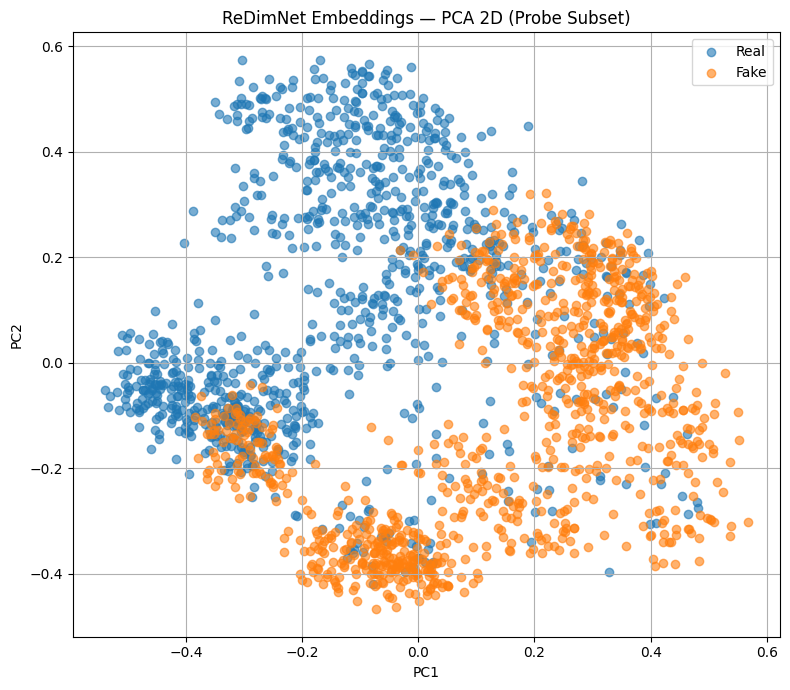

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X_probe)

plt.figure(figsize=(8, 7))

for label in np.unique(y_probe):
    idx = y_probe == label
    label_name = "Real" if label == 0 else "Fake"
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], alpha=0.6, label=label_name)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("ReDimNet Embeddings — PCA 2D (Probe Subset)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()